In [117]:
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc

In [118]:
base = pd.read_json('data/predictions/base.json')
ner = pd.read_json('data/predictions/ner_mask.json')
noise = pd.read_json('data/predictions/noise.json')
full_length = pd.read_json('data/predictions/full_length.json')
final = pd.read_json('data/predictions/final.json')

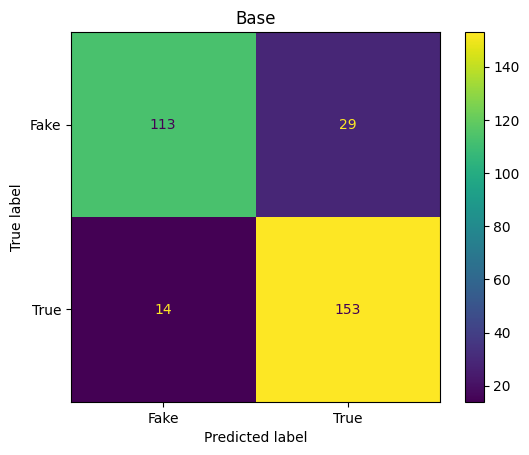

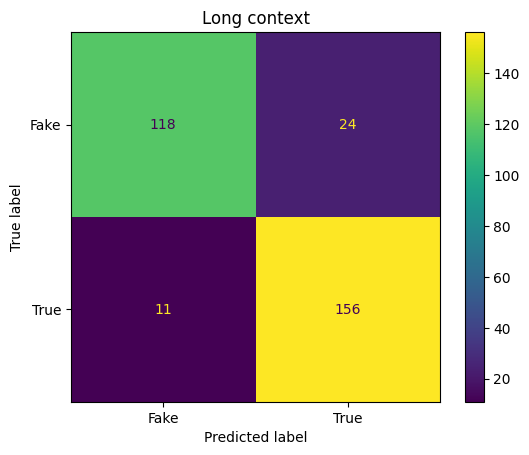

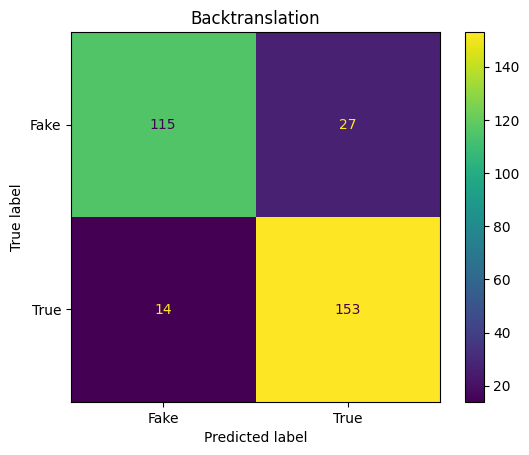

In [119]:
from utils import LABELS

models = [base, full_length, final]
nombres = ['Base', 'Long context', 'Backtranslation']

def get_confusion_matrix(df, name):
    cm = confusion_matrix(df['category'], df['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot()
    plt.title(name)
    plt.show()

for model, nombre in zip(models, nombres):
    get_confusion_matrix(model, nombre)

## Acierto

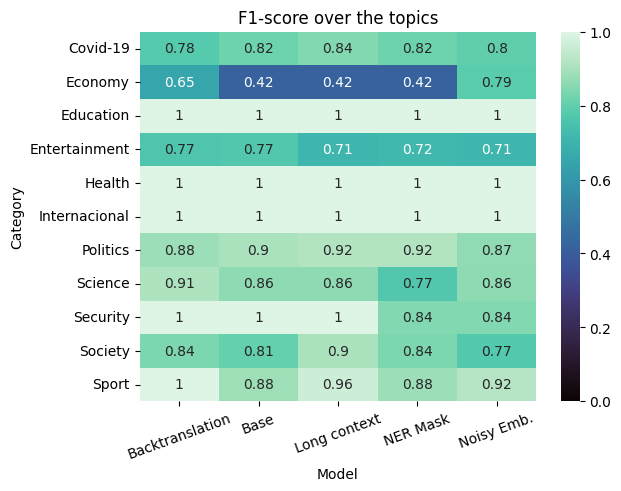

In [165]:
import seaborn as sns
from utils import LABELS

def get_report(data):
    report = {}
    for topic in data['topic'].unique():
        subset = data[data['topic'] == topic]
        report[topic] = classification_report(subset['category'].apply(lambda x: LABELS[x]), 
                                              subset['predictions'].apply(lambda x: LABELS[x]),
                                    labels=np.arange(2).tolist(),
                                    target_names=['Fake','True'],
                                    digits=4,
                                    zero_division=0,
                                    output_dict=True)
    return report

models = [base,full_length,ner,noise,final]

plt.figure()
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['Long context']*len(f1[1]) + ['NER Mask']*len(f1[2]) + ['Noisy Emb.']*len(f1[3]) + ['Backtranslation']*len(f1[4])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                     'F1-score': [score for sublist in f1 for score in sublist],
                     'Model': nombres})
#sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
sns.heatmap(data.pivot(index='Category',columns='Model',values='F1-score'), 
            annot=True, cmap='mako', # coolwarm
            vmin=0, vmax=1)
plt.xticks(rotation=20)
plt.title('F1-score over the topics')
#plt.ylim(0.3,1.1)
plt.show()

F1-score over the topics
	Mean	Ponderated
Base: 0.8600 | 0.8585
Long context: 0.8736 | 0.8850
NER Mask: 0.8369 | 0.8539
Noisy Emb: 0.8693 | 0.8353
Backtranslation: 0.8928 | 0.8653


/tmp/ipykernel_12403/4265385989.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)


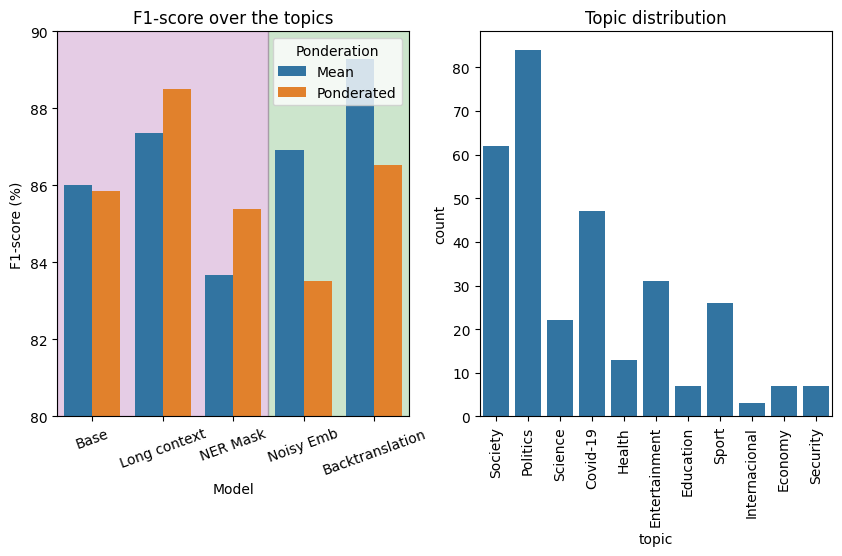

In [162]:
models = [base,full_length,ner,noise,final]
nombres = ['Base', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation']
print('F1-score over the topics')
print('\tMean\tPonderated')
data = pd.DataFrame(columns=['Model', 'F1-score (%)', 'Ponderation'])
for model, nombre in zip(models, nombres):
    scores = []
    for topic in model['topic'].unique():
        subset = model[model['topic'] == topic]
        scores.append(f1_score(subset['category'], subset['predictions'], average='macro'))
    mean = np.mean(scores)
    pond = f1_score(model["category"], model["predictions"], average="macro")
    data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
    data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': pond*100, 'Ponderation': 'Ponderated'}, index=[0])], ignore_index=True)
    print(f'{nombre}: {mean:.4f} | {pond:.4f}')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = plt.gca()

ax.axvspan(2.5, 4.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)
sns.barplot(x='Model', y='F1-score (%)', hue='Ponderation', data=data)
plt.title('F1-score over the topics')
plt.xticks(rotation=20)
plt.ylim(80,90)

plt.subplot(1,2,2)
sns.countplot(x='topic',  data=full_length, stat='count')
plt.xticks(rotation=90)
plt.title('Topic distribution')
plt.show()

## Confianza

In [147]:
from matplotlib.gridspec import GridSpec


def get_confidence_report(data, title, threshold=0.5):
    get_confidence = lambda pred: np.sqrt(np.mean(np.square(pred - threshold)))
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(2, 4, figure=fig)
    cm = np.zeros((2,2))

    fig.add_subplot(gs[0,0])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'Fake')]
    cm[0,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - Fake')

    fig.add_subplot(gs[0,1])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'True')]
    cm[0,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=10, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - True')

    fig.add_subplot(gs[1,0])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'Fake')]
    cm[1,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=5, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - Fake')

    fig.add_subplot(gs[1,1])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'True')]
    cm[1,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - True')

    big_ax = fig.add_subplot(gs[:,2:])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot(ax=big_ax, colorbar=False)
    im = big_ax.imshow(cm, interpolation='nearest', cmap='viridis', vmin=0.20, vmax=0.5)
    big_ax.figure.colorbar(im, ax=big_ax)
    plt.title('Mean confidence')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


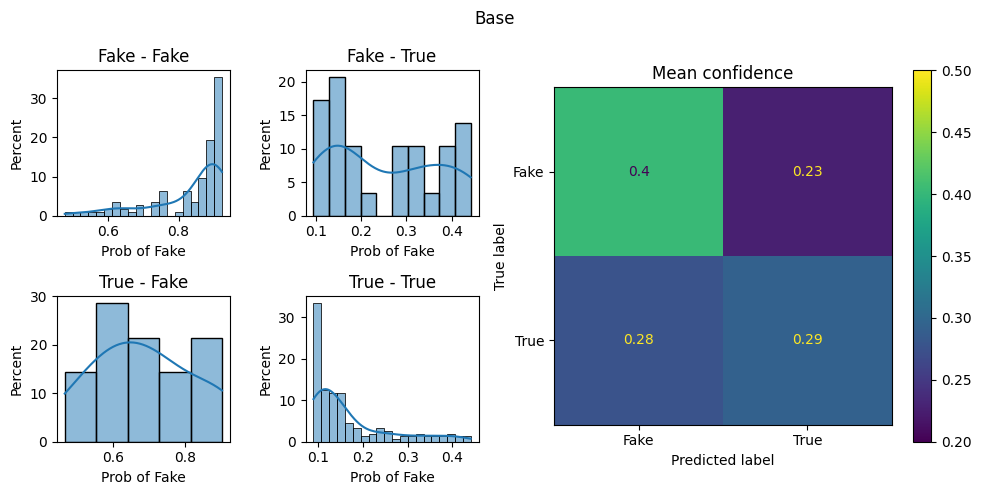

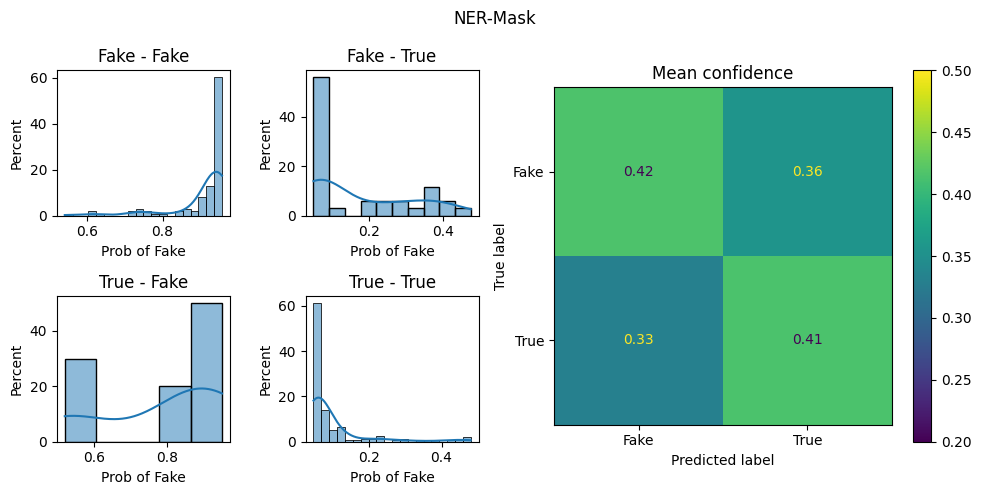

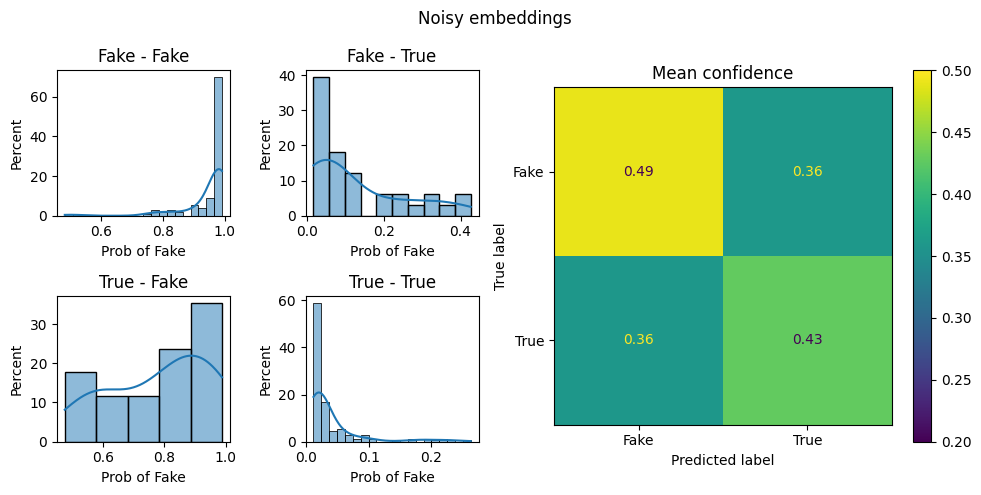

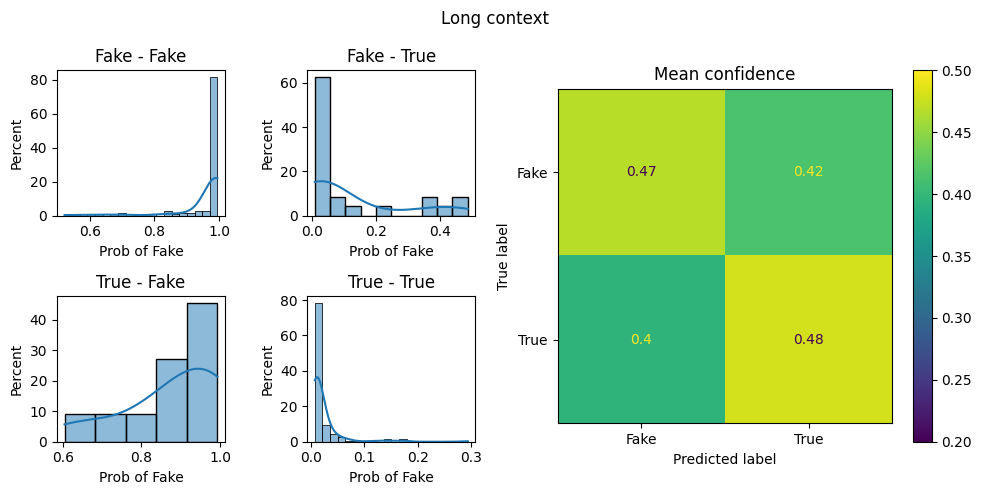

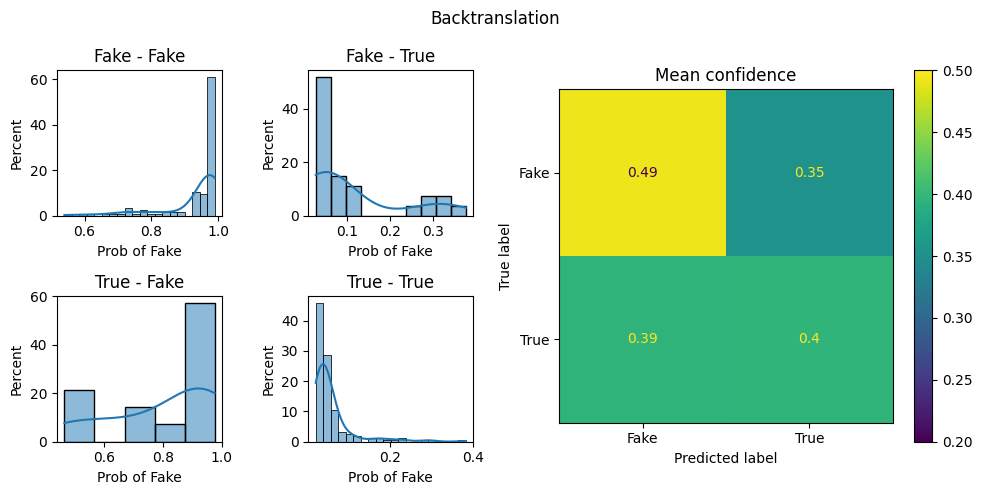

In [148]:
get_confidence_report(base, 'Base',threshold=0.44528159499168396)
get_confidence_report(ner, 'NER-Mask')
get_confidence_report(noise, 'Noisy embeddings',threshold=0.46455496549606323)
get_confidence_report(full_length, 'Long context')
get_confidence_report(final, 'Backtranslation', threshold=0.44906046986579895)

## Curva ROC

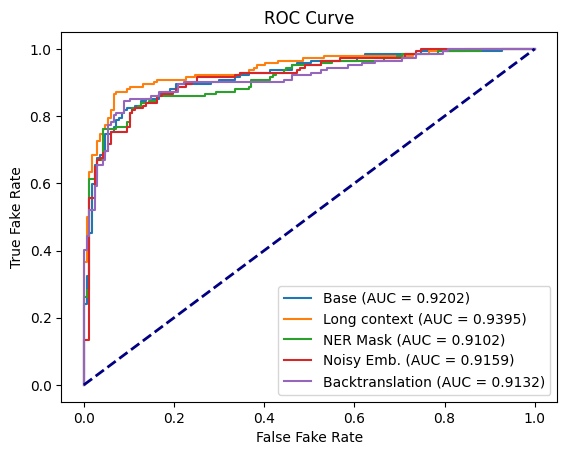

In [163]:
from sklearn.metrics import roc_curve, auc
models = [base, full_length, ner, noise, final]
nombres = ['Base', 'Long context', 'NER Mask', 'Noisy Emb.', 'Backtranslation']

plt.figure()
for model, nombre in zip(models, nombres):
    fpr, tpr, _ = roc_curve(model['category'], model['prob_fake'], pos_label='Fake')
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc(fpr, tpr):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Fake Rate')
plt.ylabel('True Fake Rate')
plt.title('ROC Curve')
plt.show()

/tmp/ipykernel_12403/1054363728.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)


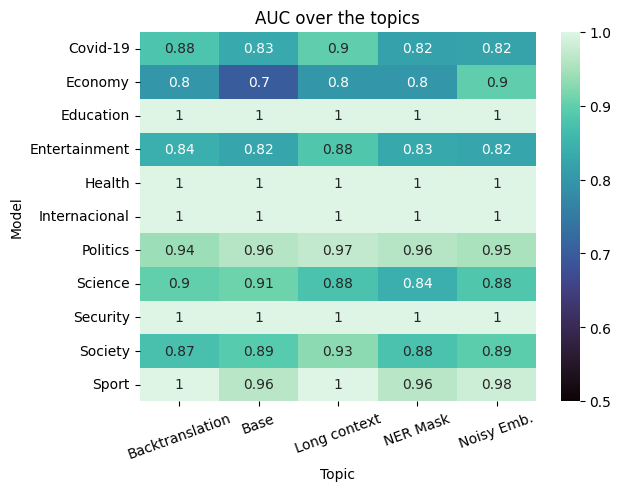

In [164]:
df = pd.DataFrame(columns=['Model', 'Topic', 'AUC'])
for model, nombre in zip(models, nombres):
    for topic in model['topic'].unique():
        subset = model[model['topic'] == topic]
        fpr, tpr, _ = roc_curve(subset['category'], subset['prob_fake'], pos_label='Fake')
        df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)

plt.figure()
sns.heatmap(df.pivot(index='Model', columns='Topic', values='AUC'), annot=True, cmap='mako', vmin=0.5, vmax=1)
plt.title('AUC over the topics')
plt.xticks(rotation=20)
plt.show()